In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math

In [2]:
%run ../codes/branchingv2.py

In [9]:
xx = list(range(1000))
xx.reverse()
r = 0.025
R0 = 2.5
p = r/(R0+r)
X_cutoff = np.zeros_like(pop)
for loc in range(num_fips):
    pop_i = pop[loc]
#     print(pop_i)
    for x_guess in xx:
        prob_x = SSA.nbinom.pmf(x_guess, r, p)
        offspring = prob_x * pop_i
        if offspring > 1:
            X_cutoff[loc] = x_guess
            break
        else:
            continue

In [14]:
M_weight_cutoff = np.zeros((num_fips, 1000))
for loc in range(num_fips):
    x = X_cutoff[loc]
    x_range = np.arange(0, x, 1)  # define the range of x values the
    pmf = SSA.nbinom.pmf(x_range, r, p)
    weights_n = pmf/np.sum(pmf)
    M_weight_cutoff[loc,:int(x)] = weights_n

In [21]:
def find_offspring_bylocation(N_inf, M_P):
    """
    Inf is the array of already infected people, [100,0,....] of N locations
    M_P is the matrix of prob with different cufoff in N locations
    """
    offsprings = []
    n_loc = len(N_inf)
    for idx in range(n_loc):
        n_infectors = N_inf[idx]
        weights_n = M_P[idx]
        tt = np.random.choice(len(weights_n), size = n_infectors, p = weights_n)
        offsprings.extend(list(tt))
    return np.array(offsprings)

In [26]:
def superspreading_T_Loc_cutoff(T, initials, nbi_para, pop, paras, WN, rand_seed, prob_cut):
    # initialise
    l0, i0 = initials
    r, p = nbi_para
    num_fips = len(pop)
    Z, Zb, D, Db = paras
    child_seeds = rand_seed.spawn(T)
    

    NewInf = np.zeros((num_fips, T))
    TotInf = np.zeros((num_fips, T))
    NewInf[l0, 0] = i0
    TotInf[:, 0] = NewInf[:, 0]

    for ti in range(T):
        infectors = np.int64(NewInf[:, ti])
        total_num_infectors = np.sum(infectors)
        pop_immu = 1-TotInf[:, ti]/pop[:]
        pop_immu[pop_immu < 0] = 0
        # create list of immu_prob * number of infectors
        immu_all = np.repeat(pop_immu, infectors)
        rng = np.random.default_rng(child_seeds[ti])
        # tt = rng.negative_binomial(r, p, total_num_infectors)

        # to be assigned, every new infections for the infector
        tt = find_offspring_bylocation(infectors, prob_cut)
        total_new = np.round(tt*immu_all)
        totoal_new_infection_loc = get_new_infections_position(
            infectors, total_new, num_fips)

        z_num = np.int64(np.sum(total_new))
        NF = np.zeros((2, z_num), dtype=np.int64)
        # for the time distribution
        latency_p = SSA.gamma.rvs(a=Z, scale=Zb, size=z_num, random_state=rng)
        infectious_p = SSA.gamma.rvs(
            a=D, scale=Db, size=z_num, random_state=rng)
        v = rng.random(z_num)
        delay_days = latency_p+v*infectious_p  # 3+5*0.5

        NF[0, :] = np.ceil(delay_days+ti)  # make it idx int
        # for the location distribution
        NF[1, :] = totoal_new_infection_loc
        df = pd.DataFrame(NF.T, columns=['time', 'o_l'])
        l_list = np.arange(num_fips)
        df['d_l'] = df['o_l'].apply(
            lambda x: np.random.choice(l_list, size=1, p=WN[:, x])[0])
        df = df[df['time'] <= (T-1)]
        NF_ii = np.array(df)
        for (t, o, d) in NF_ii:
            NewInf[d, t] = NewInf[d, t]+1
        TotInf = np.cumsum(NewInf, axis=1)

    return NewInf, TotInf

In [3]:
WN = np.loadtxt('W_avg.csv')
pop = np.loadtxt('pop_new.csv')

In [4]:
num_fips = len(pop)
T = 60
# num_ens = 100 ##300 ###500 intially when R0 gets larger, we need fewer ensemble members, std is smaller

# pathogen characteristics
Z = 3  # latent period
Zb = 1  # scale parameter for Z
D = 5  # infectious period
Db = 1  # scale parameter for b

In [28]:
l0 = 1859-1  # start with New York County NY in python -1, in matlab is 1859
i0 = 100  # the starting t=0, in matlab it is 1

E_NewInf = np.zeros((num_fips, T))
E_TotInf = np.zeros((num_fips, T))

ss = np.random.SeedSequence(0)
E_NewInf_i, E_TotInf_i = superspreading_T_Loc_cutoff(T, (l0, i0), (r, p), pop, (Z, Zb, D, Db), WN, ss, M_weight_cutoff)

In [30]:
E_daily_per_pop = E_NewInf_i[:,:]/pop[:,None]*100000
num_county = np.sum(E_daily_per_pop[:,:]>10,axis=0)

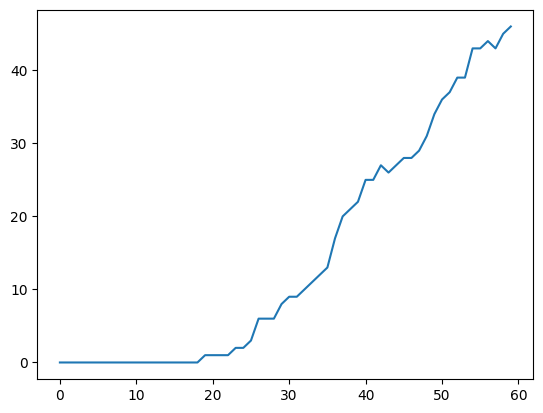

In [31]:
plt.plot(num_county)